In [1]:
### standard sci-py libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot3 as uproot ### to read, convert, inspect ROOT TTrees
import matplotlib as mpl

from hipe4ml.model_handler import ModelHandler
from hipe4ml.tree_handler import TreeHandler
from hipe4ml import analysis_utils
from hipe4ml import plot_utils

import matplotlib.ticker as mtick # for 1e10 format on Axis
import pickle5 as pickle

/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


ModuleNotFoundError: No module named 'pickle5'

In [9]:
# Loading the datasets

model = 'BDT'

# inputFile='/eos/user/h/hsharma/HyperLoop_Output_Run3/DATA_train_Lc_112997/LcData_df_0_80_new.root'; outputFile=f'/eos/user/h/hsharma/ML/MLoutput/LcTree_{model}_1_pt_110.root'
# inputFile='/eos/user/h/hsharma/HyperLoop_Output_Run3/DATA_train_Lc_112997/LcData_df_81_160_new.root'; outputFile=f'/eos/user/h/hsharma/ML/MLoutput/LcTree_{model}_2_pt_110.root'
inputFile='/eos/user/h/hsharma/HyperLoop_Output_Run3/DATA_train_Lc_112997/LcData_df_161_233_new.root'; outputFile=f'/eos/user/h/hsharma/ML/MLoutput/LcTree_{model}_3_pt_110.root'

hdl_data=TreeHandler(inputFile, "LcData")

hdl_data.apply_preselections("fM > 2.2 and fM < 2.4", inplace=True)

In [10]:
# Using Tight selection for data

tpcSigKa_min = -3
tpcSigKa_max = 3

pt_min = 1
pt_max = 10

## Selections from Cut based analysis 
cpa_min=0.95
cpa_max=1.0

DL_min=0.02

cutList=[
    f'fNSigTpcKa1 > {tpcSigKa_min}',
    f'fNSigTpcKa1 < {tpcSigKa_max}',
    f'fPt > {pt_min}',
    f'fPt < {pt_max}',
    f'fCpa > {cpa_min}',    
    f'fCpa < {cpa_max}',
    f'fDecayLength > {DL_min}'
]

allCuts = ' & '.join(cutList)
allCuts = f' {allCuts} '  # Add spaces around the string

# Applying the same Tight selection criteira for data and MC
hdl_data.apply_preselections(allCuts, inplace=True)

print('Size of samples for training \nData = ',len(hdl_data))

Size of samples for training 
Data =  1259802


In [11]:
hdl_data_application = hdl_data

nameDataSet=f'trainTestDataSets/TrainTestSet_{model}_pT_{pt_min}{pt_max}.dataframe'
df_trainTest = pickle.load(open(nameDataSet, 'rb'))
print(df_trainTest.shape[0])

df_totalData = hdl_data_application.get_data_frame()

result_df = df_totalData.merge(df_trainTest, on=list(df_totalData.columns), how='left', indicator=True)
df_application = result_df[result_df['_merge'] == 'left_only'].drop(columns=['_merge'])


hdl_data_application.set_data_frame(df_application)
print(len(hdl_data_application))

21576
1259802


In [12]:
print(df_trainTest.shape[0],len(hdl_data_application), len(hdl_data))

21576 1259802 1259802


<Axes: >

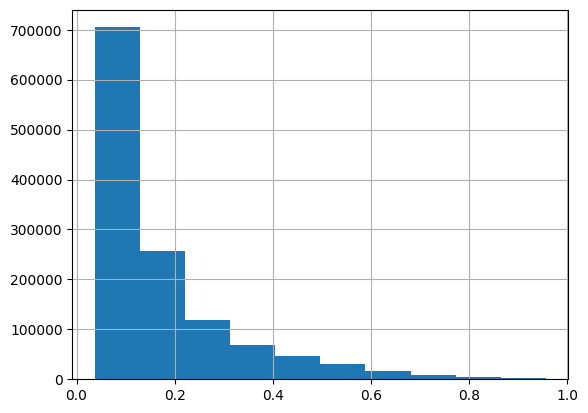

In [13]:
nameModel=f'savedModels/saved{model}_pT_{pt_min}{pt_max}.model'

model = pickle.load(open(nameModel, 'rb'))

hdl_data_application.apply_model_handler(model,output_margin=False)

output_df=hdl_data_application.get_data_frame()

# ML tree name
output_file = uproot.recreate(outputFile)

output_df['model_output'].hist()

In [14]:
# Cut selections before saving dataframe to ML trees

massMin=2.2
massMax=2.4

ptMin=0
ptMax=100

ptProng0Min=0
ptProng0Max=100

ptProng1Min=0
ptProng1Max=100

ptProng2Min=0
ptProng2Max=100

cpaMin=0.8
cpaMax=1


cutList=[
    'fM > @massMin',
    'fM < @massMax',
    'fPt > @ptMin',
    'fPt < @ptMax',
    'fPtProng0 > @ptProng0Min',
    'fPtProng0 < @ptProng0Max',
    'fPtProng1 > @ptProng1Min',
    'fPtProng1 < @ptProng1Max',
    'fPtProng2 > @ptProng2Min',
    'fPtProng2 < @ptProng2Max',
    'fCpa > @cpaMin',
    'fCpa < @cpaMax'
]

allCuts = ' & '.join(cutList)
allCuts = f' {allCuts} '  # Add spaces around the string
allCuts

dfAfterSelection = output_df.query(allCuts)
print('After applying selection, total candidates: ',dfAfterSelection.shape[0])


# pandas dataframe with the branches to be saved 
dfToSave=dfAfterSelection[['fM','fPt','model_output']]

# setting branch datatype
branch_dtype = {
    # Xic observables
    'fM': np.float64,
    'fPt': np.float64,
    'model_output': np.float64
}

# convert DF to Dict
branch_data = dfToSave.to_dict(orient='list')

# Create new tree with branches
output_file['NNoutput'] = uproot.newtree(branch_dtype)
output_file['NNoutput'].extend(branch_data)
output_file.close()

After applying selection, total candidates:  1259802
